In [1]:
import requests
import pandas as pd
import time
import os

In [2]:
# SETUP
df = pd.read_csv('train.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [3]:
# Define the output directory and create it if it doesn't exist
output_dir = "audio_files"
os.makedirs(output_dir, exist_ok=True)
# Create a list to store data ONLY for successful downloads
successful_downloads = []

In [4]:
# PROCESSING
for index, row in df.iterrows():
    dzr_id = row['dzr_sng_id']
    api_url = f"https://api.deezer.com/track/{dzr_id}"

    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            data = response.json()
            preview_url = data.get('preview')
            bpm = data.get('bpm')

            if preview_url:
                # This is a good candidate, now try to download the audio
                audio_response = requests.get(preview_url, timeout=10)
                file_path = os.path.join(output_dir, f"{dzr_id}.mp3")
                with open(file_path, 'wb') as f:
                    f.write(audio_response.content)

                # Success! Now we record everything
                print(f"Success for {dzr_id} (BPM: {bpm})")
                
                # Get the original song data from the row
                song_data = row.to_dict()
                
                # Add the new BPM value
                song_data['bpm'] = bpm
                
                # Add the complete record to our list of successes
                successful_downloads.append(song_data)
        else:
            print(f"No preview available for {dzr_id}. Skipping.")

    except requests.exceptions.ConnectionError as e:
        print(f"--> Network Error for {dzr_id}. Skipping. Error: {e}")
    except Exception as e:
        print(f"An unknown error occurred for {dzr_id}: {e}. Skipping.")
        
    # Respect API rate limits
    time.sleep(0.5)

Success for 216752 (BPM: 110)
Success for 239138 (BPM: 78.3)
Success for 266313 (BPM: 118.8)
Success for 283306 (BPM: 108.2)
Success for 286183 (BPM: 166)
Success for 301623 (BPM: 109.7)
Success for 364962 (BPM: 126.8)
Success for 365070 (BPM: 164.1)
Success for 365073 (BPM: 149.8)
Success for 365137 (BPM: 103.9)
Success for 520083 (BPM: 122.3)
Success for 530652 (BPM: 105.5)
Success for 531834 (BPM: 100.8)
Success for 531935 (BPM: 133.4)
Success for 531937 (BPM: 157.2)
Success for 531993 (BPM: 142.1)
Success for 532439 (BPM: 162.1)
Success for 532605 (BPM: 84.9)
Success for 532607 (BPM: 102.1)
Success for 532609 (BPM: 116.1)
Success for 532611 (BPM: 99.9)
Success for 533010 (BPM: 119.8)
Success for 533990 (BPM: 0)
Success for 534083 (BPM: 198.8)
Success for 534503 (BPM: 108.5)
Success for 534506 (BPM: 117.8)
Success for 534508 (BPM: 114.5)
Success for 534574 (BPM: 128)
Success for 534752 (BPM: 87)
Success for 535419 (BPM: 156)
Success for 535901 (BPM: 124.5)
Success for 536481 (BPM: 1

In [5]:
# --- FINALIZE ---
print("\n-------------------------------------------")
print(f"Download process finished.")
print(f"Total songs successfully downloaded: {len(successful_downloads)}")


-------------------------------------------
Download process finished.
Total songs successfully downloaded: 7389


In [6]:
# Create a new DataFrame from the list of successful downloads
successful_df = pd.DataFrame(successful_downloads)

In [7]:
# Save the new DataFrame to a CSV file
output_csv_path = 'downloaded_songs_with_bpm.csv'
successful_df.to_csv(output_csv_path, index=False)

print(f"Successfully saved data for downloaded songs to: {output_csv_path}")
print("\nNew DataFrame preview:")
print(successful_df.head())

Successfully saved data for downloaded songs to: downloaded_songs_with_bpm.csv

New DataFrame preview:
   dzr_sng_id          MSD_sng_id        MSD_track_id   valence   arousal  \
0      216752  SOVJXGK12A8AE4760C  TRLBHVY128F4242C31 -1.400403  1.538229   
1      239138  SOACXLC12AB018218D  TRQJZHB128F92FA42D -1.935250 -0.655810   
2      266313  SOTITAA12A6D4F8DA4  TRPMWQM128F932C0C8  1.257460  1.086515   
3      283306  SOCSRIF12AB018E4FC  TRABHPA12903CEC222  0.373325 -0.923151   
4      286183  SOCABAW12A8C135475  TRQQTKT128F426E347  1.309308  1.482917   

         artist_name               track_name    bpm  
0   Anorexia Nervosa    Stabat mater dolorosa  110.0  
1  Jimmy Witherspoon  Ain't Nobody's Business   78.3  
2        The Walkmen         Brandy alexander  118.8  
3     Duke Ellington                  Caravan  108.2  
4          Art Tatum              Tea For Two  166.0  


In [8]:
# unavailable bpms from the Deezer API were stored as 0, calculate them with librosa and store them in the csv

In [9]:
import librosa

# Loop through the dataframe to fix 0 BPM entries
for index, row in successful_df.iterrows():
    if row['bpm'] == 0:
        dzr_id = row['dzr_sng_id']
        file_path = os.path.join(output_dir, f"{dzr_id}.mp3")
        
        try:
            # Load the audio file
            y, sr = librosa.load(file_path)
            
            # Estimate the tempo
            estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
            
            # Update the DataFrame with the new value
            successful_df.loc[index, 'bpm'] = estimated_bpm
            print(f"Recalculated BPM for {dzr_id}: {estimated_bpm:.2f}")
            
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 533990: 95.70
Recalculated BPM for 564578: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 564579: 123.05
Recalculated BPM for 564580: 161.50


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 564582: 161.50
Recalculated BPM for 586544: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 600153: 123.05
Recalculated BPM for 600156: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 605870: 89.10
Recalculated BPM for 611705: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 623110: 123.05
Recalculated BPM for 623111: 123.05
Recalculated BPM for 623112: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 623387: 112.35
Recalculated BPM for 623531: 123.05
Recalculated BPM for 624195: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 624196: 95.70
Recalculated BPM for 625159: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 628247: 123.05
Recalculated BPM for 628265: 76.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 671823: 107.67
Recalculated BPM for 698255: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 698336: 99.38
Recalculated BPM for 774506: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 783011: 112.35
Recalculated BPM for 800963: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 811880: 103.36
Recalculated BPM for 811894: 73.83


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 815734: 143.55
Recalculated BPM for 815756: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 821009: 89.10
Recalculated BPM for 822750: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 846669: 161.50
Recalculated BPM for 846674: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 848651: 123.05
Recalculated BPM for 850076: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 863130: 172.27
Recalculated BPM for 869545: 89.10


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 880912: 123.05
Recalculated BPM for 884695: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 884701: 123.05
Recalculated BPM for 885440: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 885679: 143.55
Recalculated BPM for 885683: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 885686: 103.36
Recalculated BPM for 885691: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 906546: 129.20
Recalculated BPM for 906558: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 906609: 143.55
Recalculated BPM for 906612: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 906617: 152.00
Recalculated BPM for 907680: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 910021: 152.00
Recalculated BPM for 910051: 107.67
Recalculated BPM for 916534: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 916537: 117.45
Recalculated BPM for 916541: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 916770: 129.20
Recalculated BPM for 920416: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 924364: 172.27
Recalculated BPM for 924578: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 925109: 123.05
Recalculated BPM for 925111: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 925118: 123.05
Recalculated BPM for 934808: 112.35
Recalculated BPM for 934811: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 936835: 152.00
Recalculated BPM for 936925: 117.45
Recalculated BPM for 936997: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 937002: 117.45
Recalculated BPM for 939672: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 939680: 152.00
Recalculated BPM for 939685: 143.55
Recalculated BPM for 939687: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 939692: 112.35
Recalculated BPM for 940103: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 940480: 92.29
Recalculated BPM for 940489: 136.00
Recalculated BPM for 941555: 129.20
Recalculated BPM for 941558: 152.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 941561: 117.45
Recalculated BPM for 941566: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 941577: 95.70
Recalculated BPM for 941579: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 941597: 136.00
Recalculated BPM for 941600: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 941605: 86.13
Recalculated BPM for 941614: 112.35
Recalculated BPM for 941715: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 941739: 123.05
Recalculated BPM for 941763: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 942276: 99.38
Recalculated BPM for 942279: 92.29


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 942282: 129.20
Recalculated BPM for 942297: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 942511: 129.20
Recalculated BPM for 944174: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 944176: 136.00
Recalculated BPM for 944185: 136.00
Recalculated BPM for 944303: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 944309: 143.55
Recalculated BPM for 945040: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 945276: 107.67
Recalculated BPM for 945289: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 945861: 103.36
Recalculated BPM for 946031: 136.00
Recalculated BPM for 946033: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src

Recalculated BPM for 946036: 112.35
Recalculated BPM for 946038: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 946048: 161.50
Recalculated BPM for 946051: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 946054: 129.20
Recalculated BPM for 946306: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 946307: 136.00
Recalculated BPM for 946314: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 946319: 95.70
Recalculated BPM for 946323: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 948626: 112.35
Recalculated BPM for 948628: 117.45
Recalculated BPM for 948635: 123.05
Recalculated BPM for 948777: 136.00
Recalculated BPM for 948779: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 948784: 117.45
Recalculated BPM for 948786: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 948788: 89.10
Recalculated BPM for 948799: 136.00
Recalculated BPM for 948801: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 949408: 117.45
Recalculated BPM for 949423: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 950092: 152.00
Recalculated BPM for 950144: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 950284: 107.67
Recalculated BPM for 950295: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 950298: 161.50
Recalculated BPM for 950312: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 950318: 103.36
Recalculated BPM for 950319: 99.38
Recalculated BPM for 950599: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 951285: 123.05
Recalculated BPM for 951294: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 951315: 103.36
Recalculated BPM for 951318: 152.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 951320: 143.55
Recalculated BPM for 951909: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 951943: 123.05
Recalculated BPM for 953602: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 958798: 107.67
Recalculated BPM for 980358: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 980360: 117.45
Recalculated BPM for 980361: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 980367: 112.35
Recalculated BPM for 982433: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 982474: 143.55
Recalculated BPM for 982483: 152.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 982485: 89.10
Recalculated BPM for 983309: 123.05
Recalculated BPM for 983317: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 983319: 117.45
Recalculated BPM for 987748: 161.50
Recalculated BPM for 991188: 161.50
Recalculated BPM for 1026283: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1027923: 152.00
Recalculated BPM for 1043767: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1045227: 117.45
Recalculated BPM for 1082502: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1084540: 107.67
Recalculated BPM for 1087100: 95.70
Recalculated BPM for 1095988: 89.10


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 1096012: 123.05
Recalculated BPM for 1096013: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1096014: 107.67
Recalculated BPM for 1096016: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1096017: 117.45
Recalculated BPM for 1096018: 143.55
Recalculated BPM for 1096020: 129.20
Recalculated BPM for 1096022: 107.67
Recalculated BPM for 1096023: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 1100484: 143.55
Recalculated BPM for 1101103: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1101116: 103.36
Recalculated BPM for 1104506: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1104507: 117.45
Recalculated BPM for 1104511: 129.20
Recalculated BPM for 1104513: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1109953: 129.20
Recalculated BPM for 1109954: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1109955: 143.55
Recalculated BPM for 1109956: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1109965: 107.67
Recalculated BPM for 1114191: 83.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1115428: 143.55
Recalculated BPM for 1115434: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1115436: 123.05
Recalculated BPM for 1115439: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1121706: 136.00
Recalculated BPM for 1123844: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1123859: 172.27
Recalculated BPM for 1125083: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1126509: 129.20
Recalculated BPM for 1126511: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1126513: 123.05
Recalculated BPM for 1126514: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1126518: 95.70
Recalculated BPM for 1126519: 99.38
Recalculated BPM for 1129640: 92.29


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src

Recalculated BPM for 1137657: 129.20
Recalculated BPM for 1137660: 112.35
Recalculated BPM for 1140348: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1157468: 92.29
Recalculated BPM for 1157469: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1157472: 112.35
Recalculated BPM for 1157474: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1157477: 117.45
Recalculated BPM for 1157478: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1157479: 152.00
Recalculated BPM for 1157480: 117.45
Recalculated BPM for 1157483: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1157484: 143.55
Recalculated BPM for 1157854: 129.20
Recalculated BPM for 1162556: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1162561: 99.38
Recalculated BPM for 1162566: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1165541: 143.55
Recalculated BPM for 1167886: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1168339: 112.35
Recalculated BPM for 1170927: 117.45
Recalculated BPM for 1170929: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 1170930: 117.45
Recalculated BPM for 1170932: 129.20
Recalculated BPM for 1170933: 123.05
Recalculated BPM for 1171871: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1171877: 95.70
Recalculated BPM for 1171880: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 1175597: 99.38
Recalculated BPM for 1175598: 123.05
Recalculated BPM for 1175600: 86.13


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 1178165: 152.00
Recalculated BPM for 1181063: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1181068: 117.45
Recalculated BPM for 1181072: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1184316: 117.45
Recalculated BPM for 1184321: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1184322: 107.67
Recalculated BPM for 1560585: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1574409: 92.29
Recalculated BPM for 1574433: 92.29


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1574442: 117.45
Recalculated BPM for 1574660: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1574668: 99.38
Recalculated BPM for 1574674: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1574697: 95.70
Recalculated BPM for 1576042: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 1626923: 117.45
Recalculated BPM for 1985045: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2125116: 92.29
Recalculated BPM for 2125123: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2125817: 107.67
Recalculated BPM for 2129668: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2163151: 117.45
Recalculated BPM for 2172897: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2172898: 107.67
Recalculated BPM for 2172900: 143.55
Recalculated BPM for 2172904: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2177958: 112.35
Recalculated BPM for 2190532: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2190544: 123.05
Recalculated BPM for 2191385: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2191386: 152.00
Recalculated BPM for 2191387: 143.55
Recalculated BPM for 2191389: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2191390: 107.67
Recalculated BPM for 2191392: 136.00
Recalculated BPM for 2191393: 152.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 2191395: 152.00
Recalculated BPM for 2191396: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2203629: 161.50
Recalculated BPM for 2230947: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2230950: 117.45
Recalculated BPM for 2230952: 117.45
Recalculated BPM for 2230953: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2230957: 92.29
Recalculated BPM for 2231805: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2232906: 112.35
Recalculated BPM for 2243887: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2243902: 129.20
Recalculated BPM for 2252789: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2252799: 95.70
Recalculated BPM for 2293144: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2293148: 143.55
Recalculated BPM for 2293164: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2300825: 92.29
Recalculated BPM for 2314472: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2314499: 117.45
Recalculated BPM for 2317147: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2317235: 136.00
Recalculated BPM for 2317236: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2317238: 107.67
Recalculated BPM for 2317242: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2318550: 92.29
Recalculated BPM for 2318551: 172.27


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2318558: 152.00
Recalculated BPM for 2443627: 95.70
Recalculated BPM for 2460763: 95.70


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2466504: 129.20
Recalculated BPM for 2509072: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2509105: 99.38
Recalculated BPM for 2509370: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2509371: 117.45
Recalculated BPM for 2509378: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2509574: 95.70
Recalculated BPM for 2511969: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2511970: 136.00
Recalculated BPM for 2511972: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2511979: 161.50
Recalculated BPM for 2511980: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2515096: 107.67
Recalculated BPM for 2521525: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2523560: 129.20
Recalculated BPM for 2523567: 123.05
Recalculated BPM for 2534605: 184.57


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2534608: 172.27
Recalculated BPM for 2539110: 107.67
Recalculated BPM for 2539112: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 2539113: 112.35
Recalculated BPM for 2542119: 161.50


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2542120: 152.00
Recalculated BPM for 2542122: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 2542123: 152.00
Recalculated BPM for 2547688: 161.50
Recalculated BPM for 2577955: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2598229: 117.45
Recalculated BPM for 2602768: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2661876: 129.20
Recalculated BPM for 2661879: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2661885: 123.05
Recalculated BPM for 2711042: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2711043: 152.00
Recalculated BPM for 2711044: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2711048: 129.20
Recalculated BPM for 2711049: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2799818: 152.00
Recalculated BPM for 2800778: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2800781: 112.35
Recalculated BPM for 2853883: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2953168: 129.20
Recalculated BPM for 2953173: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2963871: 117.45
Recalculated BPM for 2963876: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 2963877: 92.29
Recalculated BPM for 3040988: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3041020: 161.50
Recalculated BPM for 3041046: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3062591: 129.20
Recalculated BPM for 3070894: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3090616: 123.05
Recalculated BPM for 3090622: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3090885: 99.38
Recalculated BPM for 3090886: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3090887: 117.45
Recalculated BPM for 3090888: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3090889: 99.38
Recalculated BPM for 3090890: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3090891: 107.67
Recalculated BPM for 3090893: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3090894: 95.70
Recalculated BPM for 3090896: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3090897: 99.38
Recalculated BPM for 3090898: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3091903: 161.50
Recalculated BPM for 3091905: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3092694: 83.35
Recalculated BPM for 3092696: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3092697: 117.45
Recalculated BPM for 3092700: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3092702: 123.05
Recalculated BPM for 3092705: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3101617: 99.38
Recalculated BPM for 3107400: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3107405: 117.45
Recalculated BPM for 3108472: 95.70


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3112904: 117.45
Recalculated BPM for 3112905: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3112916: 129.20
Recalculated BPM for 3119136: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3119157: 123.05
Recalculated BPM for 3119158: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3119160: 117.45
Recalculated BPM for 3119162: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3121830: 107.67
Recalculated BPM for 3121841: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3129591: 78.30
Recalculated BPM for 3130320: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3130333: 123.05
Recalculated BPM for 3133821: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3133830: 95.70
Recalculated BPM for 3135440: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3135441: 117.45
Recalculated BPM for 3135443: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3135445: 117.45
Recalculated BPM for 3135555: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3135561: 99.38
Recalculated BPM for 3137988: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3137989: 143.55
Recalculated BPM for 3137990: 123.05
Recalculated BPM for 3137991: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3137996: 103.36
Recalculated BPM for 3137999: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3141223: 129.20
Recalculated BPM for 3145866: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3151541: 129.20
Recalculated BPM for 3152010: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 3154862: 161.50
Recalculated BPM for 3154863: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3154866: 143.55
Recalculated BPM for 3156968: 107.67
Recalculated BPM for 3157071: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3164898: 143.55
Recalculated BPM for 3168914: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3173077: 136.00
Recalculated BPM for 3239962: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3239964: 123.05
Recalculated BPM for 3260806: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3339941: 112.35
Recalculated BPM for 3354100: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3359724: 123.05
Recalculated BPM for 3359727: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3513293: 107.67
Recalculated BPM for 3531417: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3532377: 107.67
Recalculated BPM for 3619511: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3658608: 161.50
Recalculated BPM for 3855171: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3868469: 136.00
Recalculated BPM for 3868474: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 3884369: 136.00
Recalculated BPM for 3902418: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4033391: 117.45
Recalculated BPM for 4033393: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4188497: 123.05
Recalculated BPM for 4188499: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4188500: 117.45
Recalculated BPM for 4188503: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4217719: 123.05
Recalculated BPM for 4244138: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4255888: 152.00
Recalculated BPM for 4256905: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4315423: 112.35
Recalculated BPM for 4604874: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4670276: 117.45
Recalculated BPM for 4677572: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4679139: 123.05
Recalculated BPM for 4686565: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4708864: 123.05
Recalculated BPM for 4711058: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 4946042: 117.45
Recalculated BPM for 5107442: 83.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 5367498: 123.05
Recalculated BPM for 5424963: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 5592952: 172.27
Recalculated BPM for 5592953: 161.50


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 5592964: 112.35
Recalculated BPM for 5606968: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 5606969: 89.10
Recalculated BPM for 5606973: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 5638730: 129.20
Recalculated BPM for 5638731: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 5638732: 123.05
Recalculated BPM for 5657989: 89.10


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 5936255: 107.67
Recalculated BPM for 6104718: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 6104726: 86.13
Recalculated BPM for 6247250: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 6248925: 103.36
Recalculated BPM for 6248928: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 6451839: 117.45
Recalculated BPM for 6494353: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 6514365: 129.20
Recalculated BPM for 7255541: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 7255545: 143.55
Recalculated BPM for 7255547: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 7634973: 112.35
Recalculated BPM for 7634976: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 7634981: 152.00
Recalculated BPM for 7634984: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 7860278: 117.45
Recalculated BPM for 7860783: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 10237970: 107.67
Recalculated BPM for 10434094: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 10535330: 123.05
Recalculated BPM for 11186374: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 11493803: 103.36
Recalculated BPM for 12180202: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 12684595: 123.05
Recalculated BPM for 12906074: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13128706: 123.05
Recalculated BPM for 13128707: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13128708: 143.55
Recalculated BPM for 13128714: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13128715: 123.05
Recalculated BPM for 13142596: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13142597: 143.55
Recalculated BPM for 13142636: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13143955: 123.05
Recalculated BPM for 13146180: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13148345: 161.50
Recalculated BPM for 13163935: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13186618: 161.50
Recalculated BPM for 13463716: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13784635: 129.20
Recalculated BPM for 13808787: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13816417: 89.10
Recalculated BPM for 13816420: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13816426: 143.55
Recalculated BPM for 13816435: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 13816448: 129.20
Recalculated BPM for 14380205: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 14525037: 161.50
Recalculated BPM for 14784307: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 15178214: 117.45
Recalculated BPM for 15178296: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 15178438: 112.35
Recalculated BPM for 15178683: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 15178685: 143.55
Recalculated BPM for 15178797: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 15523336: 117.45
Recalculated BPM for 15523338: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 15523342: 103.36
Recalculated BPM for 15523346: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 15523349: 103.36
Recalculated BPM for 17563273: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 17563277: 152.00
Recalculated BPM for 17563394: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 17694893: 117.45
Recalculated BPM for 19272281: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 19278361: 136.00
Recalculated BPM for 24433381: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 24433431: 136.00
Recalculated BPM for 24983771: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 24983821: 143.55
Recalculated BPM for 24983841: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 24983851: 103.36
Recalculated BPM for 24983871: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30225441: 117.45
Recalculated BPM for 30225521: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30438301: 99.38
Recalculated BPM for 30438311: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30438321: 117.45
Recalculated BPM for 30438341: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30438401: 117.45
Recalculated BPM for 30511571: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30511591: 123.05
Recalculated BPM for 30511611: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30511631: 92.29
Recalculated BPM for 30511641: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30514231: 136.00
Recalculated BPM for 30514241: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30514261: 99.38
Recalculated BPM for 30514271: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30514281: 99.38
Recalculated BPM for 30514301: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30514311: 86.13
Recalculated BPM for 30516701: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30517331: 136.00
Recalculated BPM for 30517341: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30517361: 107.67
Recalculated BPM for 30517371: 92.29


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30517391: 92.29
Recalculated BPM for 30517401: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 30517411: 129.20
Recalculated BPM for 32109751: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 32109771: 99.38
Recalculated BPM for 57845991: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 60725757: 92.29
Recalculated BPM for 60734859: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 61381927: 129.20
Recalculated BPM for 61381929: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 61381932: 117.45
Recalculated BPM for 61381937: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 61557876: 86.13
Recalculated BPM for 61677274: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 61706245: 123.05
Recalculated BPM for 61706258: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 61706325: 123.05
Recalculated BPM for 61706463: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 61706466: 161.50
Recalculated BPM for 61706471: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 61706472: 136.00
Recalculated BPM for 61863758: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 61863763: 129.20
Recalculated BPM for 61863765: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 61863766: 129.20
Recalculated BPM for 61863767: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 62294829: 143.55
Recalculated BPM for 62294832: 92.29


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 62294834: 152.00
Recalculated BPM for 62294835: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 62294836: 117.45
Recalculated BPM for 62418644: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 62418646: 136.00
Recalculated BPM for 62418647: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 62418648: 143.55
Recalculated BPM for 62418650: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 62418652: 117.45
Recalculated BPM for 62418664: 89.10


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 63254095: 117.45
Recalculated BPM for 63978798: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 64876735: 123.05
Recalculated BPM for 65981571: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 66537166: 136.00
Recalculated BPM for 66537168: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 66537386: 136.00
Recalculated BPM for 66538662: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 67317503: 123.05
Recalculated BPM for 67317527: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 68075342: 117.45
Recalculated BPM for 68515003: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 68515005: 129.20
Recalculated BPM for 68515135: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 68515136: 123.05
Recalculated BPM for 69096087: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 69201997: 99.38
Recalculated BPM for 69246588: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 70051871: 117.45
Recalculated BPM for 70877884: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 70877885: 95.70
Recalculated BPM for 70886708: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 70990370: 117.45
Recalculated BPM for 70990636: 143.55


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 71306384: 172.27
Recalculated BPM for 71328863: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 71508326: 117.45
Recalculated BPM for 71511142: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 71512319: 143.55
Recalculated BPM for 71955239: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 71955257: 136.00
Recalculated BPM for 72294196: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 73323493: 95.70
Recalculated BPM for 73605855: 123.05


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 73605856: 152.00
Recalculated BPM for 73878901: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 73879229: 107.67
Recalculated BPM for 73919596: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 73919598: 123.05
Recalculated BPM for 73919600: 95.70


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 73919602: 95.70
Recalculated BPM for 73919603: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 73919604: 95.70
Recalculated BPM for 73920535: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 74516186: 117.45
Recalculated BPM for 75799840: 172.27


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 75799843: 143.55
Recalculated BPM for 75799845: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 75799846: 123.05
Recalculated BPM for 75799847: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 75799850: 152.00
Recalculated BPM for 75800745: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 75800747: 136.00
Recalculated BPM for 76376859: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 76376863: 136.00
Recalculated BPM for 76376868: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 76376874: 123.05
Recalculated BPM for 76376884: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 76376887: 152.00
Recalculated BPM for 76376888: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 76376890: 129.20
Recalculated BPM for 76376892: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 76376893: 86.13
Recalculated BPM for 76376895: 161.50


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 76376898: 99.38
Recalculated BPM for 76376900: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 76376902: 129.20
Recalculated BPM for 76376904: 152.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 76376907: 112.35
Recalculated BPM for 76376909: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 76376910: 129.20
Recalculated BPM for 76376918: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 76376923: 136.00
Recalculated BPM for 76376926: 89.10


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 77879670: 92.29
Recalculated BPM for 77879672: 99.38


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 77879674: 123.05
Recalculated BPM for 77908682: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 78934650: 123.05
Recalculated BPM for 79470863: 86.13


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 79470945: 136.00
Recalculated BPM for 80354186: 86.13


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 80354238: 117.45
Recalculated BPM for 80354264: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 81939526: 112.35
Recalculated BPM for 81939540: 95.70


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 81939548: 103.36
Recalculated BPM for 82744808: 172.27


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 82744822: 129.20
Recalculated BPM for 83946427: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 83946445: 117.45
Recalculated BPM for 84340035: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 86836343: 161.50
Recalculated BPM for 86836345: 117.45


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 86836349: 143.55
Recalculated BPM for 86836355: 152.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 86836357: 172.27
Recalculated BPM for 86836361: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 88642429: 107.67
Recalculated BPM for 88903893: 161.50


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 92382340: 161.50
Recalculated BPM for 92818866: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 96529430: 103.36
Recalculated BPM for 96529434: 103.36


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 97139824: 129.20
Recalculated BPM for 103480160: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 103700062: 99.38
Recalculated BPM for 105098330: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105098876: 136.00
Recalculated BPM for 105099094: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105099096: 129.20
Recalculated BPM for 105099100: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105099102: 112.35
Recalculated BPM for 105099110: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105099112: 89.10
Recalculated BPM for 105276946: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281086: 143.55
Recalculated BPM for 105281088: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281090: 95.70
Recalculated BPM for 105281092: 86.13


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281094: 136.00
Recalculated BPM for 105281096: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281098: 117.45
Recalculated BPM for 105281102: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281146: 143.55
Recalculated BPM for 105281148: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281150: 129.20
Recalculated BPM for 105281152: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281156: 143.55
Recalculated BPM for 105281158: 99.38


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281162: 117.45
Recalculated BPM for 105281164: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281274: 95.70
Recalculated BPM for 105281280: 86.13


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281282: 112.35
Recalculated BPM for 105281284: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281286: 99.38
Recalculated BPM for 105281288: 117.45


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281290: 99.38
Recalculated BPM for 105281292: 107.67


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281294: 112.35
Recalculated BPM for 105281306: 136.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281308: 117.45
Recalculated BPM for 105281312: 103.36


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281314: 136.00
Recalculated BPM for 105281328: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281330: 99.38
Recalculated BPM for 105281332: 152.00


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281336: 117.45
Recalculated BPM for 105281344: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281350: 136.00
Recalculated BPM for 105281502: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 105281584: 107.67
Recalculated BPM for 105281586: 92.29


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105281588: 95.70
Recalculated BPM for 105281590: 95.70


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105281592: 86.13
Recalculated BPM for 105281598: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105281600: 152.00
Recalculated BPM for 105281606: 89.10


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105281614: 161.50
Recalculated BPM for 105281658: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105281784: 152.00
Recalculated BPM for 105281800: 95.70


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105291922: 129.20
Recalculated BPM for 105291924: 112.35


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105291926: 123.05
Recalculated BPM for 105291950: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105291952: 143.55
Recalculated BPM for 105291956: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105291964: 136.00
Recalculated BPM for 105292188: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105292190: 123.05
Recalculated BPM for 105426616: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105426620: 129.20
Recalculated BPM for 105426622: 95.70


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105426630: 123.05
Recalculated BPM for 105428482: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105428490: 86.13
Recalculated BPM for 105428492: 143.55


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105428496: 136.00
Recalculated BPM for 105428498: 92.29


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 105859906: 136.00
Recalculated BPM for 107546486: 136.00


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	Th

Recalculated BPM for 108558124: 103.36
Recalculated BPM for 108564262: 89.10


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 108607650: 117.45
Recalculated BPM for 108607652: 129.20


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping


Recalculated BPM for 108607662: 129.20
Recalculated BPM for 109592268: 112.35


/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 110957896: 92.29
Recalculated BPM for 111471566: 107.67


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 112659384: 152.00
Recalculated BPM for 112659436: 123.05


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 112660206: 89.10
Recalculated BPM for 112662176: 129.20


[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]
[src/libmpg123/id3.c:INT123_parse_new_id3():950] warning: ID3v2: unrealistic small tag lengh 0, skipping
/tmp/ipykernel_2370/3895921374.py:14: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  estimated_bpm = librosa.beat.tempo(y=y, sr=sr)[0]


Recalculated BPM for 112662186: 152.00
Recalculated BPM for 113389498: 103.36


In [12]:
# Loop through the dataframe to fix 0 BPM entries
for index, row in successful_df.iterrows():
    if row['bpm'] == 0:
        print(row)

In [13]:
# Now save the dataframe, which has the 0s replaced
successful_df.to_csv('downloaded_songs_with_bpm_RECALCULATED.csv', index=False)

In [15]:
# now the lyrics

In [56]:
import lyricsgenius

with open("secrets.txt") as f:
    token = f.read().strip()

GENIUS = lyricsgenius.Genius(token,
                             skip_non_songs=True,
                             remove_section_headers=True)

In [57]:
import os, pathlib

# read file and set env var
os.environ["GENIUS_ACCESS_TOKEN"] = pathlib.Path("secrets.txt").read_text().strip()

GENIUS = lyricsgenius.Genius(os.environ["GENIUS_ACCESS_TOKEN"],
                             skip_non_songs=True,
                             remove_section_headers=True)

In [77]:
import re, time

def clean(txt):
    return None if txt is None else re.sub(r"\[.*?\]", "", txt)

def strip_title(t):
    return re.sub(r"[\(\[].*?[\)\]]", "", t).split(" - ")[0].strip()

def fetch_lyrics(row):
    try:
        title  = strip_title(row["track_name"])
        artist = row["artist_name"]
        song   = GENIUS.search_song(title, artist)
        time.sleep(1) # 60 req/min
        return clean(song.lyrics) if song else None
    except Exception:
        time.sleep(1)
        return None

In [78]:
meta = pd.read_csv("train.csv", 
                   usecols=["MSD_sng_id", "artist_name", "track_name"])

# take everything
#batch = meta.copy()

# sample up to the max safely
batch_size = min(50_000, len(meta))
batch = meta.sample(batch_size, random_state=0)

In [ ]:
batch["lyrics"] = batch.apply(fetch_lyrics, axis=1)
time.sleep(1) # 60 req/min
batch.to_parquet("msd_with_genius_lyrics.parquet")

Searching for "Navigate The Seas Of The Sun" by Bruce Dickinson...


/home/georgios/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/lyricsgenius/genius.py:468: FutureWarning: The constructor signature will change in a future version. It will change to Song(lyrics, body) instead of Song(client, json_dict, lyrics).
  song = Song(self, song_info, lyrics)


Done.
Searching for "I.o.u." by Freeez...
Done.
Searching for "Notice Of Eviction" by Saul Williams...
Done.
Searching for "Atrophy" by The Red Jumpsuit Apparatus...
Done.
Searching for "Man" by the bird and the bee...
Done.
Searching for "Where Did He Go" by Keri Hilson...
Done.
Searching for "High Lonesome" by Jesse Malin...
Done.
Searching for "There's Always Someone Cooler Than You" by Ben Folds...
Done.
Searching for "Darkness On The Edge Of Town" by Bruce Springsteen...
No results found for: 'Darkness On The Edge Of Town Bruce Springsteen'
Searching for "Hometown Waltz" by Rufus Wainwright...
Done.
Searching for "I'll Fly For You" by Spandau Ballet...
Done.
Searching for "Embryonic" by Riverside...
Done.
Searching for "Remember The Times" by Lucy Pearl...
Done.
Searching for "I'll Go Crazy If I Don't Go Crazy Tonight" by U2...
Done.
Searching for "My Side Of The Bed" by Susanna Hoffs...
Done.
Searching for "The Rain" by Calvin Harris...
Done.
Searching for "Searching" by Roy Ayer

In [85]:
import pandas as pd

df = pd.read_parquet("msd_with_genius_lyrics.parquet")
print(df.shape) # (7400, 4)  ← rows, cols
df.head()

(11267, 4)


,MSD_sng_id,artist_name,track_name,lyrics
9702,SOSAPVN12AB017EDE7,Bruce Dickinson,Navigate The Seas Of The Sun,7 ContributorsNavigate the Seas of the Sun Lyr...
1467,SOHTAJS12A8C13AECB,Freeez,I.o.u.,14 ContributorsI.O.U. LyricsI.O.U. (song)\nFro...
10857,SODROXC12AB017F4B5,Saul Williams,Notice Of Eviction,1 ContributorNotice of Eviction LyricsSomethin...
4604,SONQPDO12AF72A5839,The Red Jumpsuit Apparatus,Atrophy,5 ContributorsAtrophy Lyrics\nDon't tell me th...
4677,SOWBOBE12AF729CFD9,the bird and the bee,Man,"2 ContributorsMan LyricsDon't, don't, don't, d..."


In [92]:
df.iloc[0, 3]

"7 ContributorsNavigate the Seas of the Sun LyricsThis song is inspired by author Erich von Däniken’s theory about extraterrestrial presence on Earth long ago and about man dealing with that in the future. The lyrics describe how we will venture to the stars… Read More\xa0\nDistant earthrise long ago\nLingers at the borders of our minds\nMysteries spinning in the dark\nIn the frozen emptiness of time\nWe were lost and we never knew\nWho we were or what we left behind\nLiving half-lives, we were blind\nTo the new frontiers\nThat opened up our eyes\n\nTo find our minds were spinning\nSouls entwined in a spiral dance\nThe ancient ways have found us\nAgain to give us one last chance\n\nLiving in this place\nStaring into space we find\nWe might share the corners of our lives\nInfinity runs deep\nEternity that we can't keep\nMelting through the frozen wastes of time\n\nSo we go and will not return\nTo navigate the seas of the sun\nOur children will go on and on\nTo navigate the seas of the s

In [86]:
lyrics_df = (
    pd.read_parquet("msd_with_genius_lyrics.parquet")
      .loc[:, ["MSD_sng_id", "lyrics"]]      # keep only id + text
)

In [96]:
import re

def clean_lyrics(raw: str | None) -> str | None:
    if not isinstance(raw, str):
        return None

    txt = raw.replace("\xa0", " ")                     # kill NBSP

    # A. n Contributors … Lyrics   → drop
    txt = re.sub(r"^\s*\d+\s+Contributors.*?Lyrics", "", txt, flags=re.S)

    # B. Anything up to “Read More” (Genius intro)     → drop
    txt = re.sub(r"^.*?Read More\s*", "", txt, flags=re.S | re.I)

    # C. Strip section tags  [Chorus]  etc.
    txt = re.sub(r"\[.*?]", "", txt)

    # D. First line often still descriptive.
    #    Heuristic: if first line > 8 words, discard it.
    lines = [ln.strip() for ln in txt.splitlines() if ln.strip()]
    while lines and len(lines[0].split()) > 8:
        lines.pop(0)
    txt = "\n".join(lines)

    # E. Normalise whitespace
    txt = re.sub(r"[ \t]+", " ", txt)
    txt = re.sub(r"\n{3,}", "\n\n", txt)

    return txt.strip()

In [97]:
lyrics_df["lyrics"] = lyrics_df["lyrics"].apply(clean_lyrics)

In [98]:
print(lyrics_df["lyrics"].str.len().describe())
print(lyrics_df["lyrics"].iloc[0][:400])

count    11031.000000
mean       357.111776
std        315.381319
min          0.000000
25%        122.000000
50%        228.000000
75%        608.000000
max       3396.000000
Name: lyrics, dtype: float64
Distant earthrise long ago
Lingers at the borders of our minds
Mysteries spinning in the dark
In the frozen emptiness of time
We were lost and we never knew
Who we were or what we left behind
Living half-lives, we were blind
To the new frontiers
That opened up our eyes


In [100]:
print(lyrics_df["lyrics"].str.startswith("Distant earthrise").sum())
print(lyrics_df["lyrics"].str.contains("Contributors").any())
print(lyrics_df["lyrics"].str.contains("Read More").any())

1
False
False


In [101]:
# drop tracks that ended up empty
clean_df = df[df["lyrics"].str.len() > 0].copy()

# keep only songs with ≥ 50 chars
clean_df = clean_df[clean_df["lyrics"].str.len() >= 50]

In [102]:
lyrics_df = clean_df[["MSD_sng_id", "lyrics"]]

merged = successful_df.merge(
    lyrics_df,
    on="MSD_sng_id", #join key
    how="left" # keep rows from successful_df
)

print(f"Lyrics coverage: {merged['lyrics'].notna().mean():.1%}")

Lyrics coverage: 97.8%


In [104]:
merged.to_parquet("full_dataset.parquet")
merged.to_csv("full_dataset.csv", index=False)

In [135]:
# unwanted duplicates of the exact track
dup_tracks = df.duplicated("MSD_track_id").sum()
print("duplicate TR rows:", dup_tracks)   # expect 0

duplicate TR rows: 0


In [136]:
song_counts = (df.groupby("MSD_sng_id")["MSD_track_id"]
                 .nunique()
                 .value_counts()
                 .sort_index())
print(song_counts.head())
# e.g.  1 recording: 6500 songs
#       2 recordings:  300 songs

MSD_track_id
1    7389
Name: count, dtype: int64


In [164]:
import pandas as pd, pathlib

BAD_IDS = {"936997", "2577955", "1602790"}          # dzr_sng_id values
ID_COLS = ["dzr_sng_id", "dzr_id","MSD_sng_id", "MSD_track_id", "MSD_sng_id"]                  # both variants you found
FILES = [
    "successful_with_lyrics.csv",
    "successful_with_lyrics.parquet",
    "successful_df_bpm_fixed.parquet",
    "downloaded_songs_with_bpm.csv",
    "downloaded_songs_with_bpm_RECALCULATED.csv",
    "full_dataset.csv",
    "full_dataset.parquet",
    "msd_with_genius_lyrics.parquet",
    "train.csv",
]

def purge(path):
    p = pathlib.Path(path)
    if not p.exists():
        return

    # --- load --------------------------------------------------------------
    df = pd.read_csv(p)           if p.suffix == ".csv"     else \
         pd.read_parquet(p)       if p.suffix == ".parquet" else None
    if df is None:
        return

    # --- drop bad rows -----------------------------------------------------
    for col in ID_COLS:
        if col in df.columns:
            df = df[~df[col].astype(str).isin(BAD_IDS)]

    # --- drop the song‑id column if present --------------------------------
    df = df.drop(columns=[c for c in df.columns if c.startswith("MSD_sng_")], errors="ignore")

    # --- save back ---------------------------------------------------------
    if p.suffix == ".csv":
        df.to_csv(p, index=False)
    else:
        df.to_parquet(p)

    print(f"{p.name:35} → rows {len(df):5}")

for f in FILES:
    purge(f)

successful_with_lyrics.csv          → rows  7386
successful_with_lyrics.parquet      → rows  7386
successful_df_bpm_fixed.parquet     → rows  7386
downloaded_songs_with_bpm.csv       → rows  7386
downloaded_songs_with_bpm_RECALCULATED.csv → rows  7386
full_dataset.csv                    → rows  7221
full_dataset.parquet                → rows  7221
msd_with_genius_lyrics.parquet      → rows 11267
train.csv                           → rows 11264


In [14]:
import re, pandas as pd, numpy as np

def clean_lyrics(raw):
    if not isinstance(raw, str) or not raw.strip():
        return None
    txt = raw

    # 1. clip intros ending in “Read More”
    txt = re.sub(r"(?s)^.*?Read\s+More\s*", "", txt, flags=re.I)

    # 2. drop “123 Contributors … Lyrics” header
    txt = re.sub(r"(?s)^\s*\d+\s+Contributors?.*?Lyrics\s*", "", txt, flags=re.I)

    # 3. drop “Translations …” block
    txt = re.sub(r"(?s)^Translations.*?\n", "", txt, flags=re.I)

    # 4. strip section tags like [Chorus]
    txt = re.sub(r"\[.*?]", "", txt)

    # 5. remove ShellPageBot junk
    txt = re.sub(r"Page needs help.*ShellPageBot\s*", "", txt, flags=re.I)

    # 6. normalise whitespace
    txt = txt.replace("\xa0", " ")
    txt = re.sub(r"[ \t]+", " ", txt)
    txt = re.sub(r"\n{3,}", "\n\n", txt)

    return txt.strip() or None

df = pd.read_parquet("full_dataset.parquet")

df["lyrics"] = df["lyrics"].apply(clean_lyrics)

# one‑line replacement on both artist_name and lyrics
df["artist_name"] = df["artist_name"].str.replace("BeyoncÃ©", "Beyoncé", regex=False)
df["lyrics"]      = df["lyrics"].str.replace("BeyoncÃ©", "Beyoncé", regex=False)

# how many still blank?
blank = df["lyrics"].isna() | df["lyrics"].str.strip().eq("")
print("blank lyric rows:", blank.sum())      # should be the same 165 or fewer

# save back
df.to_parquet("full_dataset.parquet")
df.to_csv("full_dataset.csv", index=False)

blank lyric rows: 1


In [15]:
def fix_mojibake(s):
    """If text was decoded as latin‑1 instead of UTF‑8, undo it."""
    try:
        return s.encode("latin1").decode("utf8")
    except (UnicodeEncodeError, UnicodeDecodeError, AttributeError):
        return s          # leave unchanged if not affected or not a string

df = pd.read_parquet("full_dataset.parquet")

# apply once to every text column you care about
for col in ["artist_name", "lyrics"]:
    df[col] = df[col].apply(fix_mojibake)

# quick check
print(df.loc[df["artist_name"].str.contains("Beyoncé", na=False), "artist_name"].unique())
# → ['Beyoncé']

df.to_parquet("full_dataset.parquet")
df.to_csv("full_dataset.csv", index=False)

['Beyoncé' 'Beyoncé feat. Jay-Z']


In [10]:
import pandas as pd

df = pd.read_parquet("full_dataset.parquet")        # 7 386 rows

# 1 ── identify blanks (NaN OR only whitespace)
mask_blank = df["lyrics"].isna() | df["lyrics"].str.strip().eq("")

print("blank lyric rows:", mask_blank.sum())        # e.g. 42

# quick peek
print(df.loc[mask_blank, ["MSD_track_id", "artist_name", "track_name"]].head())

blank lyric rows: 1
            MSD_track_id artist_name                        track_name
2537  TRGRESS128F92CAA49     Beyoncé  Single Ladies (Put A Ring On It)


In [16]:
!pip install langdetect   # ≈ 40 kB, pure‑Python

/bin/bash: /home/georgios/miniconda3/envs/tf-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 28.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'langdetect' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'langdetect'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993284 sha256=b541e8fa44a8d8aa40081e2de81dd36ba0eed934f2c6b8794fcd6212d876f587
  Stored in directory: /home/georgios/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully b

In [17]:
from langdetect import detect, LangDetectException

def is_english(text):
    try:
        return detect(text) == "en"
    except LangDetectException:
        return False        # empty or unrecognisable

df["is_english"] = df["lyrics"].apply(lambda t: is_english(t) if isinstance(t, str) else False)
df = df[df["is_english"]].reset_index(drop=True)
print("kept English rows:", len(df))

kept English rows: 7192


In [21]:
import pandas as pd

# file names of final datasets
CSV_FILE  = "full_dataset.csv"
PARQ_FILE = "full_dataset.parquet"

df = pd.read_parquet(PARQ_FILE)

# drop the helper column if it’s still there
bad_columns = ["is_english", "key_est", "mode_est"]
for bad_col in bad_columns:
    if bad_col in df.columns:
        df = df.drop(columns= bad_col)

df.to_parquet(PARQ_FILE)
df.to_csv(CSV_FILE, index=False)

In [172]:
# BPM calculation

In [28]:
import os, warnings, ctypes
import librosa, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# silence C‑level mpg123 warnings (fd 2 → /dev/null)
libc = ctypes.CDLL(None)
devnull_fd = os.open(os.devnull, os.O_WRONLY)
libc.dup2(devnull_fd, 2)

# silence the librosa tempo alias warning
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=r".*librosa\.beat\.tempo.*"
)

AUDIO_DIR = Path(output_dir)
FILE_IN   = "full_dataset.parquet"
FILE_OUT  = "full_dataset_bpm.parquet"

In [29]:
# helpers
def canonical(b, lo=80, hi=160):
    if pd.isna(b) or b == 0:
        return np.nan
    while b < lo:  b *= 2
    while b >= hi: b /= 2
    return round(b, 2)

def bpm_estimate(fpath: Path):
    try:
        y, sr = librosa.load(fpath, mono=True)
        return round(float(librosa.beat.tempo(y=y, sr=sr)[0]), 2)
    except Exception:
        return np.nan

def diff_flag(a, b, tol=3):
    if pd.isna(a) or pd.isna(b): # ignore if either missing
        return False
    return abs(a - b) >= tol

In [30]:
# load data & rename raw tag
df = pd.read_parquet(FILE_IN).copy() # has column 'bpm'
df.rename(columns={"bpm": "orig_bpm"}, inplace=True)
df["orig_bpm"] = df["orig_bpm"].apply(canonical)  # canonical tag

In [31]:
# estimate BPM
est = [bpm_estimate(AUDIO_DIR / f"{dzr}.mp3") for dzr in tqdm(df["dzr_sng_id"],
                                                              desc="BPM")]
df["est_bpm"] = pd.Series(est).apply(canonical)

BPM:   0%|          | 0/7192 [00:00<?, ?it/s]

In [32]:
# diff flag
df["bpm_diff_flag"] = df.apply(lambda r: diff_flag(r["orig_bpm"], r["est_bpm"]),
                               axis=1)

print("tracks with ≥ 3 BPM diff:", df["bpm_diff_flag"].sum())

tracks with ≥ 3 BPM diff: 1847


In [33]:
# put the BPM columns after the 'lyrics' column
cols = list(df.columns)
lyr_idx = cols.index("lyrics") + 1

# remove the three bpm columns from the list
for c in ["orig_bpm", "est_bpm", "bpm_diff_flag"]:
    cols.remove(c)

# insert them in desired order
cols[lyr_idx:lyr_idx] = ["orig_bpm", "est_bpm", "bpm_diff_flag"]

df = df[cols]

In [34]:
# save
df.to_parquet(FILE_OUT)
df.to_csv(FILE_OUT.replace(".parquet", ".csv"), index=False)

In [38]:
print(df["est_bpm"].describe())
print("Min:", df["est_bpm"].min(), "Max:", df["est_bpm"].max())

count    7192.000000
mean      116.821432
std        19.891289
min        80.750000
25%        99.380000
50%       117.450000
75%       129.200000
max       156.600000
Name: est_bpm, dtype: float64
Min: 80.75 Max: 156.6


In [40]:
print("zeros in orig_bpm :", (df["orig_bpm"] == 0).sum())
print("zeros in est_bpm  :", (df["est_bpm"]  == 0).sum())
print("NaNs in est_bpm_   :", df["est_bpm"].isna().sum())

zeros in orig_bpm : 0
zeros in est_bpm  : 0
NaNs in est_bpm_   : 0


In [197]:
# Calculate keys

In [198]:
#!pip install -U pip wheel
#!pip install cython "numpy>=1.23"

/bin/bash: /home/georgios/miniconda3/envs/tf-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
/bin/bash: /home/georgios/miniconda3/envs/tf-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 8.9 MB/s eta 0:00:00a 0:00:01


In [199]:
# 2.  build madmom from PyPI (re‑use the env you just built)
#!pip install --no-build-isolation madmom

/bin/bash: /home/georgios/miniconda3/envs/tf-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached madmom-0.16.1.tar.gz (20.0 MB)
  Preparing metadata (setup.py) ... one
  DEPRECATION: Building 'madmom' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'madmom'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for madmom: filename=madmom-0.16.1-cp311-cp311-linux_x86_64.whl size=20067685 sha256=2f6b7ec12bd202f21a4fc10f9840be066a10ef209bc30ba397b14026242ee2ef
  Stored in directory: /home/georgios/.cache/pip/wheels/3d/22/f4/40bff827ae4af4c924c7bb56b33d8183e4cf0d95c5d140c4cf
Successfully built madmom


In [46]:
import os, warnings, librosa, numpy as np, pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

In [70]:
import numpy as np
# quick shims for deprecated aliases (NumPy ≥1.24)
if not hasattr(np, 'float'):
    np.float   = float
    np.int     = int
    np.complex = complex
    np.bool    = bool
    np.object  = object

import collections, collections.abc
collections.MutableSequence = collections.abc.MutableSequence

from madmom.features.key import (
    CNNKeyRecognitionProcessor,
    key_prediction_to_label, # converts 24‑dim vector → 'C major'
)
from pathlib import Path
import pandas as pd, numpy as np

key_proc = CNNKeyRecognitionProcessor()   # pre‑trained model

In [2]:
df = pd.read_parquet("full_dataset.parquet").reset_index(drop=True)

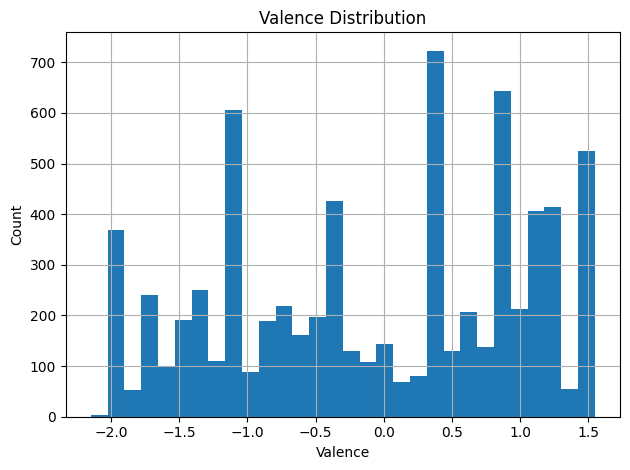

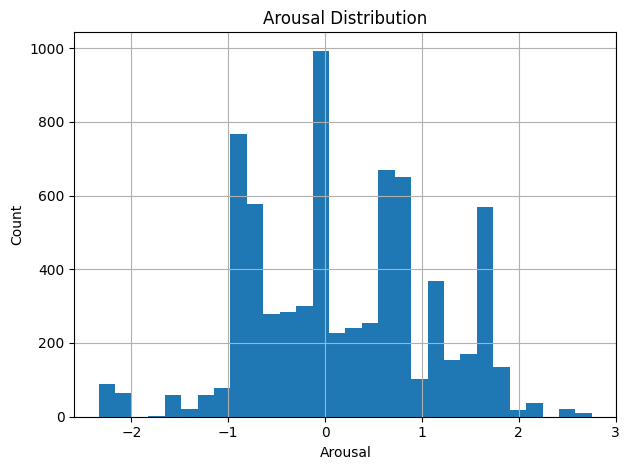

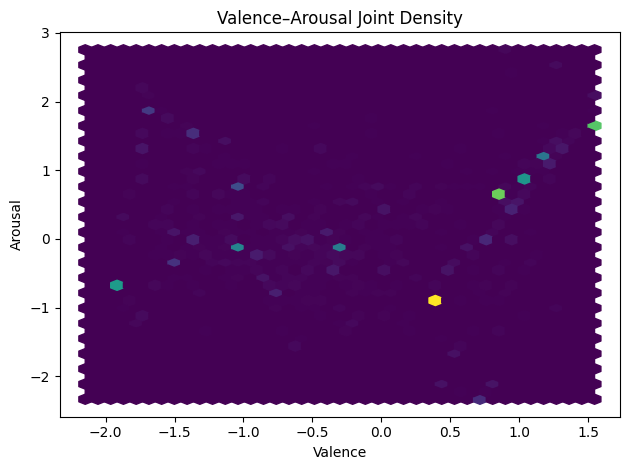

In [3]:
import matplotlib.pyplot as plt

# Valence histogram
plt.figure()
df['valence'].hist(bins=30)          # auto color
plt.xlabel('Valence')
plt.ylabel('Count')
plt.title('Valence Distribution')
plt.tight_layout()
plt.show()

# Arousal histogram
plt.figure()
df['arousal'].hist(bins=30)
plt.xlabel('Arousal')
plt.ylabel('Count')
plt.title('Arousal Distribution')
plt.tight_layout()
plt.show()

# (Optional) 2D density / hex (if allowed) – single plot: distribution shape
plt.figure()
plt.hexbin(df['valence'], df['arousal'], gridsize=40)
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title('Valence–Arousal Joint Density')
plt.tight_layout()
plt.show()

In [6]:
import numpy as np, scipy.stats as st

eps = 0.05
p_emp = ((df['arousal'].between(-eps, eps)).sum()) / len(df)
# If data were N(0,1):
p_theory = st.norm.cdf(eps) - st.norm.cdf(-eps)
print(p_emp, p_theory, p_emp / p_theory)

0.047830923248053395 0.03987761167674497 1.19944302672335


In [7]:
vals = np.sort(df['arousal'].round(4).values)
diffs = np.diff(vals)
# Small set of unique rounded values?
uniq = pd.Series(df['arousal'].round(3)).value_counts().head(20)
print(uniq)

arousal
-0.923    673
 0.662    514
 1.704    498
-0.656    368
 0.847    351
-0.066    302
 1.183    256
-0.103    238
 0.736    155
 1.842    118
-0.361    103
 0.391     96
 1.538     87
-2.334     80
-0.038     77
-0.789     53
 1.437     50
 0.005     45
 0.096     41
-0.093     40
Name: count, dtype: int64


In [75]:
df = pd.read_parquet("full_dataset.parquet").reset_index(drop=True)

# add empty string columns with the right dtype
for col in ["key_est", "mode_est"]:
    if col not in df.columns:
        df[col] = pd.Series(dtype="object")   # <- string‑friendly dtype
    else:
        df[col] = df[col].astype("object")    # cast if already exists

In [76]:
def estimate_key(path: Path):
    try:
        probs  = key_proc(str(path))              # ndarray shape (24,)
        label  = key_prediction_to_label(probs)   # e.g. 'F# minor'
        key, mode = label.split()             # 'F#', 'minor'
        return key, mode
    except Exception as e:
        print(f"fail → {path.name} : {e}")
        return np.nan, np.nan

In [77]:
for i, row in tqdm(df.iterrows(), total=len(df), desc="Key estimation"):
    if pd.notna(row["key_est"]):        # already filled, skip
        continue

    mp3 = AUDIO_DIR / f"{row['dzr_sng_id']}.mp3"
    if mp3.exists():
        key, mode = estimate_key(mp3)
        df.at[i, "key_est"]  = key
        df.at[i, "mode_est"] = mode

Key estimation:   0%|          | 0/7192 [00:00<?, ?it/s]

In [78]:
df.to_parquet("full_dataset_with_keys.parquet")
df.to_csv("full_dataset_with_keys.csv", index=False)
print("Key estimation done — saved with new columns.")

Key estimation done — saved with new columns.


In [79]:
print(df[["dzr_sng_id", "key_est", "mode_est"]].head())

   dzr_sng_id key_est mode_est
0      216752       G    minor
1      239138      Bb    major
2      266313      Bb    major
3      283306       C    minor
4      301623       C    minor


In [118]:
import pandas as pd, numpy as np

FILE_IN  = "full_dataset_with_keys.parquet"
FILE_OUT = "full_dataset_filtered.parquet"

df = pd.read_parquet(FILE_IN)

# ── drop rows with <20 words in the lyric text ────────────────
mask_enough_words = df["lyrics"].fillna("").str.split().str.len().ge(20)
df = df[mask_enough_words].reset_index(drop=True)

print(f"Remaining tracks: {len(df)} / {mask_enough_words.size}")

df.to_parquet(FILE_OUT)
df.to_csv(FILE_OUT.replace(".parquet", ".csv"), index=False)

Remaining tracks: 7191 / 7192


In [119]:
# see which one was dropped
df_orig = pd.read_parquet(FILE_IN)

In [120]:
dropped = df_orig[~mask_enough_words][["dzr_sng_id", "track_name", "lyrics"]]
print(dropped.iloc[0, :2])          # id & title
print("\nLyric (raw):\n", dropped.iloc[0]["lyrics"])

dzr_sng_id            934462
track_name    Beautiful Dirt
Name: 1006, dtype: object

Lyric (raw):
 number-4

number-4
Blow


In [122]:
df.to_parquet("full_dataset.parquet")
df.to_csv("full_dataset.csv", index=False)

In [123]:
MASTER_PATH = "full_dataset_bpm.parquet"      # has lyrics, BPM, etc.
KEY_PATH    = "full_dataset_with_keys.parquet"        # result of madmom loop

In [124]:
import pandas as pd

master = pd.read_parquet(MASTER_PATH)
keys   = pd.read_parquet(KEY_PATH)[["dzr_sng_id", "key_est", "mode_est"]]

merged = master.merge(keys, on="dzr_sng_id", how="left")

In [125]:
merged.to_parquet("full_dataset.parquet")
merged.to_csv("full_dataset.csv", index=False)

In [126]:
print( merged[["key_est", "mode_est"]].isna().mean() )
# fraction of rows where key/mode is missing

key_est     0.0
mode_est    0.0
dtype: float64


In [151]:
!pip install --upgrade "pyarrow==20.0.0"

/bin/bash: /home/georgios/miniconda3/envs/tf-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 9.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 19.0.0
    Uninstalling pyarrow-19.0.0:
      Successfully uninstalled pyarrow-19.0.0


In [82]:
df_msd = pd.read_parquet('full_dataset_with_metadata.parquet')

In [83]:
df_msd.head()

,dzr_sng_id,MSD_track_id,valence,arousal,artist_name,track_name,lyrics,orig_bpm,est_bpm,bpm_diff_flag,key_est,mode_est,msd_key,msd_mode,msd_key_conf,msd_mode_conf,msd_loudness
0,216752,TRLBHVY128F4242C31,-1.400403,1.538229,Anorexia Nervosa,Stabat mater dolorosa,We are the Sun\nWe are the dead stars\nWe are ...,110.0,112.35,False,G,minor,G,major,0.636,0.538,-7.027
1,239138,TRQJZHB128F92FA42D,-1.935250,-0.655810,Jimmy Witherspoon,Ain't Nobody's Business,One day we got ham and bacon\nThe next day ain...,78.3,156.60,True,Bb,major,D,minor,0.169,0.295,-10.016
2,266313,TRPMWQM128F932C0C8,1.257460,1.086515,The Walkmen,Brandy alexander,Finally close the door\nYou'd left open wide\n...,118.8,117.45,False,Bb,major,D#,major,0.015,0.390,-7.058
3,283306,TRABHPA12903CEC222,0.373325,-0.923151,Duke Ellington,Caravan,Night\nAnd stars above that shine so bright\nT...,108.2,107.67,False,C,minor,G#,major,0.275,0.403,-18.194
4,301623,TRDLPSL128F92FA016,1.071901,0.846830,Ella Fitzgerald,Lullaby Of Birdland,"Oh, lullaby of Birdland, that's what I\nAlways...",109.7,112.35,False,C,minor,F,minor,0.420,0.373,-9.526


In [84]:
old   = pd.read_parquet("full_dataset.parquet",        columns=["MSD_track_id"])
new   = pd.read_parquet("full_dataset_with_metadata.parquet", columns=["MSD_track_id"])

extra   = set(new["MSD_track_id"]) - set(old["MSD_track_id"])
missing = set(old["MSD_track_id"]) - set(new["MSD_track_id"])

print("extra rows :", len(extra))
print("missing rows:", len(missing))

extra rows : 0
missing rows: 0


In [76]:
df_msd.to_csv("../data/DEEZER/full_dataset_with_metadata.csv", index=False)

In [21]:
import sqlite3, pathlib, sys, textwrap

# CONFIG
MSD_DB = pathlib.Path("track_metadata.db")

# connect
if not MSD_DB.exists():
    sys.exit(f"DB file not found at {MSD_DB}")

con = sqlite3.connect(MSD_DB)
cur = con.cursor()

matches_found = 0
total_checked = 0

# query
for track_id in df_msd["MSD_track_id"]:
    total_checked += 1
    print(f"Checking: {track_id}")
    
    q = """
    SELECT
        track_id,
        title
    FROM songs
    WHERE track_id = ?
    """
    
    cur.execute(q, (track_id,))
    rows = cur.fetchall()
    
    # pretty print
    if not rows:
        print("No matches found.")
    else:
        matches_found += 1
        for r in rows:
            print(textwrap.dedent(f"""
            ─────────────────────────────────────────────────────────
            track_id               : {r[0]}
            title                  : {r[1]}
            """).strip())

print(f"\nSummary: Found {matches_found} matches out of {total_checked} track IDs checked")
print(f"Match rate: {matches_found/total_checked*100:.1f}%")

con.close()

Checking: TRLBHVY128F4242C31
─────────────────────────────────────────────────────────
track_id               : TRLBHVY128F4242C31
title                  : Stabat mater dolorosa
Checking: TRQJZHB128F92FA42D
─────────────────────────────────────────────────────────
track_id               : TRQJZHB128F92FA42D
title                  : Ain't Nobody's Business
Checking: TRPMWQM128F932C0C8
─────────────────────────────────────────────────────────
track_id               : TRPMWQM128F932C0C8
title                  : Brandy alexander
Checking: TRABHPA12903CEC222
─────────────────────────────────────────────────────────
track_id               : TRABHPA12903CEC222
title                  : Caravan
Checking: TRDLPSL128F92FA016
─────────────────────────────────────────────────────────
track_id               : TRDLPSL128F92FA016
title                  : Lullaby Of Birdland
Checking: TRPFENS128F92DF6C6
─────────────────────────────────────────────────────────
track_id               : TRPFENS128F92DF6C

In [89]:
"""
MSD High-Confidence Validation Logic
Compare MSD 'ground truth' with madmom predictions using high-confidence data only
"""
import pandas as pd
import numpy as np

def create_validation_subset(df, confidence_threshold=0.7):
    """
    Create a high-confidence subset from MSD data to validate madmom predictions.
    
    Args:
        df: DataFrame with MSD and madmom prediction columns
        confidence_threshold: Minimum confidence (default 0.7)
    
    Returns:
        DataFrame with validation flags
    """
    df = df.copy()
    
    # Create high-confidence filters
    df['msd_key_high_conf'] = (df['msd_key_conf'] >= confidence_threshold) & df['msd_key'].notna()
    df['msd_mode_high_conf'] = (df['msd_mode_conf'] >= confidence_threshold) & df['msd_mode'].notna()
    
    # Create validation subsets
    df['key_validation_eligible'] = df['msd_key_high_conf'] & df['key_est'].notna()
    df['mode_validation_eligible'] = df['msd_mode_high_conf'] & df['mode_est'].notna()
    df['full_validation_eligible'] = df['key_validation_eligible'] & df['mode_validation_eligible']
    
    return df

def calculate_validation_stats(df):
    """Calculate simple validation statistics"""
    stats = {}
    
    # Key validation
    key_subset = df[df['key_validation_eligible']]
    if len(key_subset) > 0:
        key_matches = (key_subset['msd_key'] == key_subset['key_est']).sum()
        stats['key_count'] = len(key_subset)
        stats['key_matches'] = key_matches
        stats['key_accuracy'] = key_matches / len(key_subset)
    
    # Mode validation
    mode_subset = df[df['mode_validation_eligible']]
    if len(mode_subset) > 0:
        mode_matches = (mode_subset['msd_mode'] == mode_subset['mode_est']).sum()
        stats['mode_count'] = len(mode_subset)
        stats['mode_matches'] = mode_matches
        stats['mode_accuracy'] = mode_matches / len(mode_subset)
    
    # Full validation (both key and mode correct)
    full_subset = df[df['full_validation_eligible']]
    if len(full_subset) > 0:
        both_correct = ((full_subset['msd_key'] == full_subset['key_est']) & 
                       (full_subset['msd_mode'] == full_subset['mode_est'])).sum()
        stats['full_count'] = len(full_subset)
        stats['both_correct'] = both_correct
        stats['full_accuracy'] = both_correct / len(full_subset)
    
    return stats

def print_validation_summary(df, stats):
    """Print concise validation summary"""
    print("MADMOM VALIDATION RESULTS")
    print("=" * 40)
    print(f"Dataset size: {len(df):,}")
    print(f"High-confidence MSD tracks: {df['msd_key_high_conf'].sum():,}")
    print()
    
    if 'key_count' in stats:
        print(f"Key validation:")
        print(f"  Sample size: {stats['key_count']:,}")
        print(f"  Accuracy: {stats['key_matches']:,}/{stats['key_count']:,} ({stats['key_accuracy']:.1%})")
        print()
    
    if 'mode_count' in stats:
        print(f"Mode validation:")
        print(f"  Sample size: {stats['mode_count']:,}")
        print(f"  Accuracy: {stats['mode_matches']:,}/{stats['mode_count']:,} ({stats['mode_accuracy']:.1%})")
        print()
    
    if 'full_count' in stats:
        print(f"Full validation (key + mode):")
        print(f"  Sample size: {stats['full_count']:,}")
        print(f"  Accuracy: {stats['both_correct']:,}/{stats['full_count']:,} ({stats['full_accuracy']:.1%})")

In [90]:
def main_validation_workflow(df, confidence_threshold=0.7):
    """Simplified validation workflow"""
    print("Creating validation subsets...")
    df_validated = create_validation_subset(df, confidence_threshold)
    
    print("Calculating statistics...")
    stats = calculate_validation_stats(df_validated)
    
    print_validation_summary(df_validated, stats)
    
    return df_validated, stats

In [93]:
for threshold in range(7, 10):
    df_validated, validation_stats = main_validation_workflow(df_msd, threshold/10)

    # # Get validation subsets
    key_validation_subset = df_validated[df_validated['key_validation_eligible']]
    mode_validation_subset = df_validated[df_validated['mode_validation_eligible']]
    full_validation_subset = df_validated[df_validated['full_validation_eligible']]
    print('######################################################################################')

🔍 Creating validation subsets...
📊 Calculating statistics...
🎵 MADMOM VALIDATION RESULTS
Dataset size: 7,192
High-confidence MSD tracks: 1,559

Key validation:
  Sample size: 1,559
  Accuracy: 889/1,559 (57.0%)

Mode validation:
  Sample size: 1,063
  Accuracy: 899/1,063 (84.6%)

Full validation (key + mode):
  Sample size: 809
  Accuracy: 493/809 (60.9%)
######################################################################################
🔍 Creating validation subsets...
📊 Calculating statistics...
🎵 MADMOM VALIDATION RESULTS
Dataset size: 7,192
High-confidence MSD tracks: 844

Key validation:
  Sample size: 844
  Accuracy: 498/844 (59.0%)

Mode validation:
  Sample size: 342
  Accuracy: 290/342 (84.8%)

Full validation (key + mode):
  Sample size: 236
  Accuracy: 151/236 (64.0%)
######################################################################################
🔍 Creating validation subsets...
📊 Calculating statistics...
🎵 MADMOM VALIDATION RESULTS
Dataset size: 7,192
High-confid